In [1]:
# # We use uv for faster installation
!pip install uv
!uv pip install --pre -q autogluon.timeseries --system

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 284.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import pandas as pd

# This code will read the Parquet files you uploaded.
# It requires either the 'pyarrow' or 'fastparquet' library to be installed.
# You can install them by running:
# pip install pyarrow
# or
# pip install fastparquet

try:
    # Read the 2024 dataset
    df_2024 = pd.read_parquet('./aircraft_nyc_hourly_r6_2024.parquet')
    print("Successfully loaded aircraft_nyc_hourly_r6_2024.parquet")
    print(df_2024.head())

    # Read the 2025 dataset
    df_2025 = pd.read_parquet('./aircraft_nyc_hourly_r6_2025.parquet')
    print("\nSuccessfully loaded aircraft_nyc_hourly_r6_2025.parquet")
    print(df_2025.head())

except ImportError:
    print("Could not read the Parquet files because either 'pyarrow' or 'fastparquet' is not installed.")
    print("Please install one of them to proceed.")
except FileNotFoundError:
    print("One of the files was not found. Make sure the file paths are correct.")

Successfully loaded aircraft_nyc_hourly_r6_2024.parquet
                  timestamp               h3        lat        lon  \
0 2024-01-01 00:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
1 2024-01-01 01:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
2 2024-01-01 02:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
3 2024-01-01 03:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
4 2024-01-01 04:00:00+00:00  862a10007ffffff  40.858416 -73.781928   

   num_of_aircrafts  
0                 3  
1                 1  
2                 0  
3                 1  
4                 1  

Successfully loaded aircraft_nyc_hourly_r6_2025.parquet
                  timestamp               h3        lat        lon  \
0 2025-01-01 00:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
1 2025-01-01 01:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
2 2025-01-01 02:00:00+00:00  862a10007ffffff  40.858416 -73.781928   
3 2025-01-01 03:00:00+00:00  862a10007ffffff  40.85841

In [4]:
!pip install pandas numpy h3 torch


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
# ==============================================================================
# FINAL AND COMPLETE PREPROCESSING SCRIPT (UPDATED FOR GRAPHWAVENET 4D)
# ==============================================================================
import pandas as pd
import numpy as np
import h3
import torch
import os

# --- PART 2: DATA CLEANING AND PREPARATION FUNCTION ---
def prepare_dataframe(df, name):
    """Applies all cleaning steps to a dataframe in the correct order."""
    print(f"\n--- Cleaning and Preparing {name} Data ---")
    df_copy = df.copy()

    # Step 1: Rename columns
    df_copy.rename(columns={'num_of_aircrafts': 'target', 'h3': 'item_id'}, inplace=True)

    # Step 2: Ensure timestamp is datetime
    df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

    # Step 3: Fill missing hourly gaps
    print(f"Step 3: Filling missing hourly gaps for {name}...")
    def fill_gaps_for_group(group):
        group = group.set_index('timestamp')
        group_resampled = group.resample('H').first()
        group_resampled['target'] = group_resampled['target'].interpolate(method='linear')
        static_cols = ['lat', 'lon']
        group_resampled[static_cols] = group_resampled[static_cols].fillna(method='ffill')
        group_resampled['item_id'] = group['item_id'].iloc[0]
        return group_resampled.reset_index()
    
    df_filled = df_copy.groupby('item_id').apply(fill_gaps_for_group).reset_index(drop=True)

    # Step 4: Remove timezone
    print(f"Step 4: Removing timezone information from {name}...")
    if pd.api.types.is_datetime64_any_dtype(df_filled['timestamp']) and df_filled['timestamp'].dt.tz is not None:
        df_filled['timestamp'] = df_filled['timestamp'].dt.tz_convert(None)

    print(f"--- Finished preparing {name} data ---")
    return df_filled


# Load and clean data
df_2024_clean = prepare_dataframe(df_2024, "2024 Training")
df_2025_clean = prepare_dataframe(df_2025, "2025 Evaluation")


# --- PART 3: SAVE PREPARED DATA FOR AUTOGLUON ---
print("\n--- Part 3: Saving cleaned data for AutoGluon ---")
df_2024_clean.to_csv('autogluon_final_train_data.csv', index=False)
df_2025_clean.to_csv('autogluon_final_eval_data.csv', index=False)
print("✅ AutoGluon CSVs saved.")


# --- PART 4: PREPARE AND SAVE DATA FOR GRAPHWAVENET ---
print("\n--- Part 4: Preparing and Saving data for GraphWaveNet ---")

# 4.1 Graph connectivity
all_nodes = sorted(pd.concat([df_2024_clean['item_id'], df_2025_clean['item_id']]).unique())
node_indices = {node: i for i, node in enumerate(all_nodes)}
adj_matrix = np.zeros((len(all_nodes), len(all_nodes)), dtype=np.float32)
for node, i in node_indices.items():
    neighbors = h3.grid_ring(node, 1)
    for neighbor in neighbors:
        if neighbor in node_indices:
            j = node_indices[neighbor]
            adj_matrix[i, j] = 1.0

edge_index, edge_weight = [], []
for i in range(len(all_nodes)):
    for j in range(len(all_nodes)):
        if adj_matrix[i, j] > 0:
            edge_index.append([i, j])
            edge_weight.append(adj_matrix[i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float32)

static_features_df = pd.concat([df_2024_clean, df_2025_clean]).groupby('item_id')[['lat', 'lon']].mean().reindex(all_nodes)
node_covariates = torch.tensor(static_features_df.values, dtype=torch.float32)

torch.save(edge_index, 'edge_index.pt')
torch.save(edge_weight, 'edge_weight.pt')
torch.save(node_covariates, 'node_covariates.pt')
print("✅ Graph connectivity files saved.")


# 4.2 Create 4D feature tensors [N, T, F=1]
# 4.2 Create 4D feature tensors [N, T, F=1]
feature_matrix_train = df_2024_clean.pivot_table(
    index='timestamp', columns='item_id', values='target'
).reindex(columns=all_nodes).fillna(0)
feature_matrix_eval  = df_2025_clean.pivot_table(
    index='timestamp', columns='item_id', values='target'
).reindex(columns=all_nodes).fillna(0)

# Convert to tensors and add feature dimension
target_tensor_train = torch.tensor(feature_matrix_train.values, dtype=torch.float32).permute(1,0).unsqueeze(-1)  # [N, T, F=1]
target_tensor_eval  = torch.tensor(feature_matrix_eval.values, dtype=torch.float32).permute(1,0).unsqueeze(-1)

mask_tensor_train = torch.ones_like(target_tensor_train).bool()
mask_tensor_eval  = torch.ones_like(target_tensor_eval).bool()

# --- ADD BATCH DIMENSION FOR GRAPHWAVENET ---
target_tensor_train = target_tensor_train.unsqueeze(0)  # [B=1, N, T, F]
target_tensor_eval  = target_tensor_eval.unsqueeze(0)
mask_tensor_train   = mask_tensor_train.unsqueeze(0)
mask_tensor_eval    = mask_tensor_eval.unsqueeze(0)

# Save tensors
torch.save(target_tensor_train, 'train_target_tensor.pt')
torch.save(mask_tensor_train, 'train_mask_tensor.pt')
torch.save(target_tensor_eval, 'eval_target_tensor.pt')
torch.save(mask_tensor_eval, 'eval_mask_tensor.pt')

# --- Shape verification ---
print("\n--- Verifying tensor shapes ---")
print("Train tensor shape [B, N, T, F]:", target_tensor_train.shape)
print("Eval tensor shape  [B, N, T, F]:", target_tensor_eval.shape)
print("Train mask shape  [B, N, T, F]:", mask_tensor_train.shape)
print("Eval mask shape   [B, N, T, F]:", mask_tensor_eval.shape)



--- Cleaning and Preparing 2024 Training Data ---
Step 3: Filling missing hourly gaps for 2024 Training...
Step 4: Removing timezone information from 2024 Training...
--- Finished preparing 2024 Training data ---

--- Cleaning and Preparing 2025 Evaluation Data ---
Step 3: Filling missing hourly gaps for 2025 Evaluation...
Step 4: Removing timezone information from 2025 Evaluation...
--- Finished preparing 2025 Evaluation data ---

--- Part 3: Saving cleaned data for AutoGluon ---
✅ AutoGluon CSVs saved.

--- Part 4: Preparing and Saving data for GraphWaveNet ---
✅ Graph connectivity files saved.

--- Verifying tensor shapes ---
Train tensor shape [B, N, T, F]: torch.Size([1, 1387, 8760, 1])
Eval tensor shape  [B, N, T, F]: torch.Size([1, 1387, 5448, 1])
Train mask shape  [B, N, T, F]: torch.Size([1, 1387, 8760, 1])
Eval mask shape   [B, N, T, F]: torch.Size([1, 1387, 5448, 1])


For Autogloun

In [5]:
import pandas as pd


df_2024=pd.read_csv('./autogluon_final_train_data.csv')
df_2025=pd.read_csv('./autogluon_final_eval_data.csv')
# Reset the index to make 'timestamp' a regular column again
df_2024.reset_index(inplace=True)
df_2025.reset_index(inplace=True)

# Convert timestamp column back to datetime objects (this step might be redundant if already done, but included for robustness)

df_2024.rename(columns={
    'h3': 'item_id',
    'num_of_aircrafts': 'target'
}, inplace=True)

df_2025.rename(columns={
    'h3': 'item_id',
    'num_of_aircrafts': 'target'
}, inplace=True)

# Display the first few rows of the prepared training data
print("--- Training Data Prepared for AutoGluon ---")
print(df_2024.head())

--- Training Data Prepared for AutoGluon ---
   index            timestamp          item_id        lat        lon  target
0      0  2024-01-01 00:00:00  862a10007ffffff  40.858416 -73.781928     3.0
1      1  2024-01-01 01:00:00  862a10007ffffff  40.858416 -73.781928     1.0
2      2  2024-01-01 02:00:00  862a10007ffffff  40.858416 -73.781928     0.0
3      3  2024-01-01 03:00:00  862a10007ffffff  40.858416 -73.781928     1.0
4      4  2024-01-01 04:00:00  862a10007ffffff  40.858416 -73.781928     1.0


In [6]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Convert both dataframes to TimeSeriesDataFrame format
train_ts_df = TimeSeriesDataFrame.from_data_frame(
    df_2024,
    id_column='item_id',
    timestamp_column='timestamp'
)

eval_ts_df = TimeSeriesDataFrame.from_data_frame(
    df_2025,
    id_column='item_id',
    timestamp_column='timestamp'
)

print("Data loaded and prepared successfully.\n")

Data loaded and prepared successfully.



In [7]:
# ==============================================================================
# PART 2: TRAIN THE MODEL ON 2024 DATA
# ==============================================================================
print("--- Part 2: Training the Model on 2024 Data ---")
prediction_length = 12  # Predict the next 12 hours
model_path = "autogluon_aircraft_model"  # Folder to save the model

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path=model_path,
    target='target',
    freq='H',
    eval_metric='MAE'  # Mean Absolute Error
)

# Train the model. This will take a few minutes.
predictor.fit(
    train_ts_df,
    presets="medium_quality",
    time_limit=300
)

print("Model training complete.\n")




/usr/local/lib/python3.11/dist-packages/autogluon/timeseries/predictor.py:198: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(self.freq)
Frequency 'H' stored as 'h'
Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to '/workspace/data/aircrafts_dataset/autogluon_aircraft_model'


--- Part 2: Training the Model on 2024 Data ---


=================== System Info ===================
AutoGluon Version:  1.4.1b20250818
Python Version:     3.11.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
CPU Count:          8
GPU Count:          1
Memory Avail:       449.23 GB / 503.51 GB (89.2%)
Disk Space Avail:   115075.88 GB / 558684.74 GB (20.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 300,
 'verbosity': 2}

Provided train_data has 12150120 rows, 1387 time series. Median time series length is 8760 (min=8760, max=8760). 

Provided data contains

Model training complete.




--- Part 4: Making and Plotting Clear, Overlapping Predictions ---


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


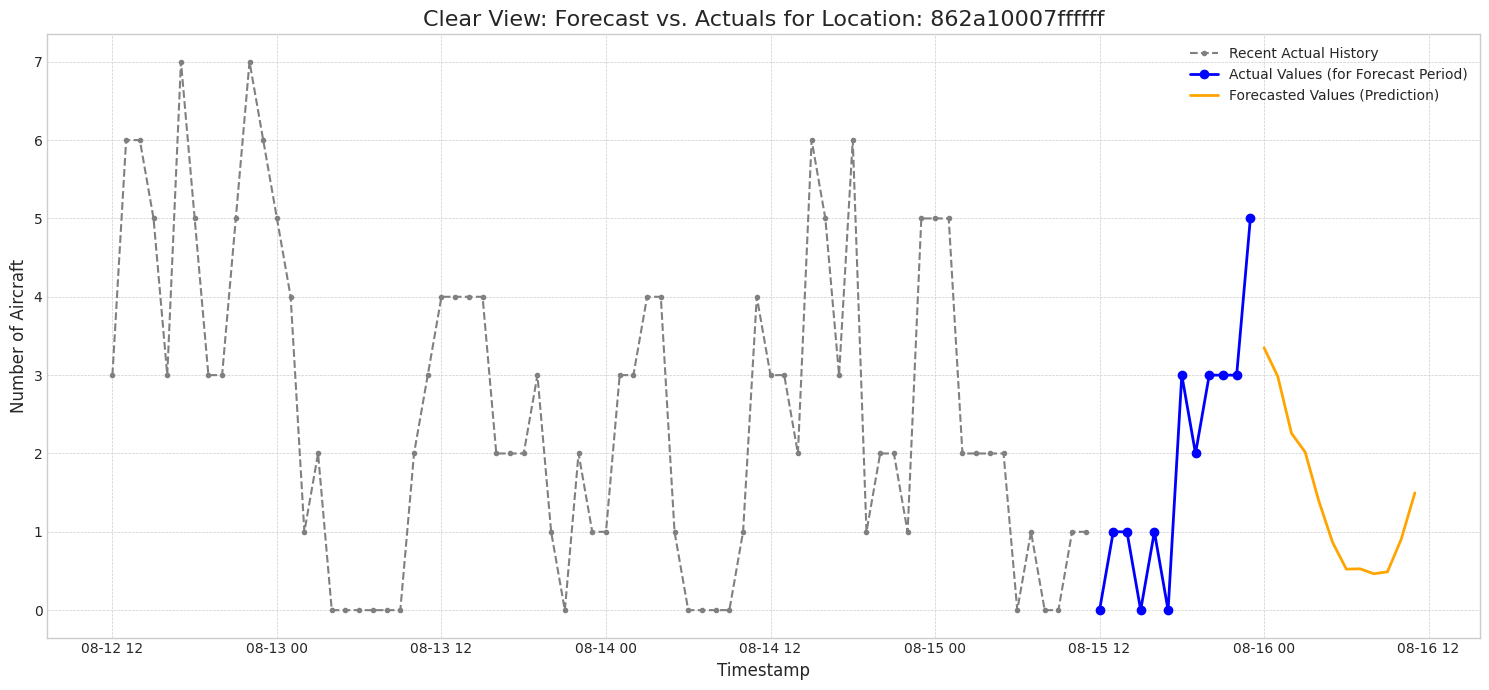

In [8]:
# ==============================================================================
# PART 4: MAKE PREDICTIONS AND PLOT CLEARLY (Improved Version)
# ==============================================================================
print("\n--- Part 4: Making and Plotting Clear, Overlapping Predictions ---")

# This part remains the same
predictions = predictor.predict(eval_ts_df)
one_item_id = eval_ts_df.item_ids[0]
y_past = eval_ts_df.loc[one_item_id]['target'] # The actual 2025 data
y_pred = predictions.loc[one_item_id]      # The model's prediction

# --- New and Improved Plotting ---
try:
    import matplotlib.pyplot as plt
    # Use a nice-looking style for the plot
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(15, 7))

    # 1. Plot the recent history (e.g., the last 72 hours before the prediction)
    # This gives context without cluttering the plot.
    recent_past = y_past.iloc[:-prediction_length]
    plt.plot(
        recent_past.tail(72),
        label="Recent Actual History",
        color="gray",
        linestyle='--',
        marker='.'
    )

    # 2. Plot the actual values from the evaluation period (the part we are predicting)
    # We use bold markers to make this part stand out.
    actual_eval_period = y_past.iloc[-prediction_length:]
    plt.plot(
        actual_eval_period,
        label="Actual Values (for Forecast Period)",
        color="blue",
        marker='o',
        linestyle='-',
        linewidth=2
    )

    # 3. Plot the model's prediction
    # This will overlap directly with the actual evaluation values.
    plt.plot(
        y_pred["mean"],
        label="Forecasted Values (Prediction)",
        color="orange",
        linestyle='-',
        linewidth=2
    )

    # Add title and labels for clarity
    plt.title(f"Clear View: Forecast vs. Actuals for Location: {one_item_id}", fontsize=16)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Number of Aircraft", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout() # Adjust layout to make room for labels
    plt.show()

except ImportError:
    print("\nPlotting requires matplotlib. Please run: pip install matplotlib")


In [11]:
pip install tabulate


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


--- Part 3: Detailed Evaluation on 2025 Data ---


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


|   RMSE |    MAE |   MAPE |    WQL | Model                     |
|--------|--------|--------|--------|---------------------------|
| 1.9305 | 0.7731 | 0.5574 | 0.5146 | AutoGluon (With Location) |

--- Part 4: Plotting by Merging Actual and Predicted Data ---


Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


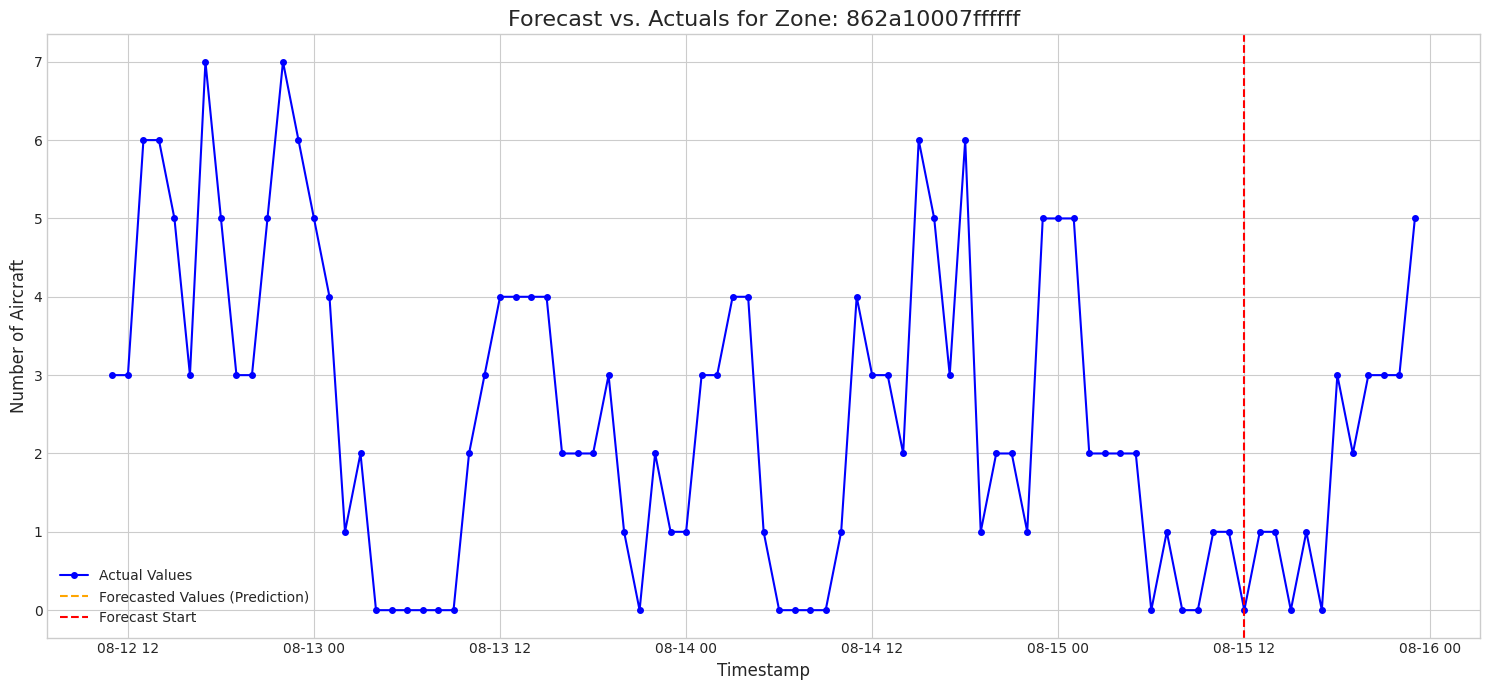

In [12]:
# PART 3: DETAILED EVALUATION ON 2025 DATA (Updated)
import matplotlib.pyplot as plt
from tabulate import tabulate
# ==============================================================================
print("--- Part 3: Detailed Evaluation on 2025 Data ---")

# Calculate specific evaluation metrics on the 2025 data
metrics = predictor.evaluate(eval_ts_df, metrics=["MAE", "RMSE", "MAPE", "WQL"])

# Create a results table using the 'tabulate' library
results_table = [
    [abs(metrics['RMSE']), abs(metrics['MAE']), abs(metrics['MAPE']), abs(metrics['WQL']), "AutoGluon (With Location)"]
]
headers = ["RMSE", "MAE", "MAPE", "WQL", "Model"]
print(tabulate(results_table, headers=headers, floatfmt=".4f", tablefmt="github"))


# ==============================================================================
# PART 4: CREATE PLOT BY MERGING DATA (Updated)
# ==============================================================================
print("\n--- Part 4: Plotting by Merging Actual and Predicted Data ---")

# Generate predictions on the 2025 evaluation data
predictions = predictor.predict(eval_ts_df)

# Select a sample location to visualize
sample_zone = eval_ts_df.item_ids[0]

# Extract actual data for the sample zone
actual_df = eval_ts_df.loc[sample_zone].reset_index()
actual_df = actual_df.rename(columns={'target': 'actual'})

# Extract predicted data for the sample zone
forecast_df = predictions.loc[sample_zone].reset_index()

# Merge the actual and forecasted dataframes on the timestamp
merged_df = pd.merge(actual_df, forecast_df, on='timestamp', how='left')

# Filter the data to show a clear, "zoomed-in" view
# We'll show the last 72 hours of history plus the 12-hour forecast period
history_start_time = merged_df['timestamp'].max() - pd.Timedelta(hours=(72 + prediction_length))
viz_df = merged_df[merged_df['timestamp'] >= history_start_time]

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))

# Plot the actual values
plt.plot(viz_df['timestamp'], viz_df['actual'], label='Actual Values', color='blue', marker='o', markersize=4)

# Plot the predicted values
plt.plot(viz_df['timestamp'], viz_df['mean'], label='Forecasted Values (Prediction)', color='orange', linestyle='--')

# Add a vertical line to show where the forecast begins
forecast_start_time = viz_df['timestamp'].max() - pd.Timedelta(hours=prediction_length - 1)
plt.axvline(x=forecast_start_time, color='r', linestyle='--', label='Forecast Start')

plt.title(f'Forecast vs. Actuals for Zone: {sample_zone}', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Number of Aircraft', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()